In [97]:
import pandas as pd
import datetime as dt
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
import missingno as msno

import matplotlib.pyplot as plt
# from census import Census
# from us import states
import os
from dotenv import load_dotenv
import requests

# from pyzipcode import ZipCodeDatabase

In [83]:
### download storm data
storm_url = 'https://www.ncei.noaa.gov/pub/data/swdi/stormevents/csvfiles/'
file_list = list(pd.read_html(storm_url, skiprows=2)[0]['Parent Directory'].dropna())
years_to_dl = range(1996, 2022, 1) ##download data for 1996 on, no flood data prior
filename_to_dl = [f for f in file_list if 'details-ftp_v1.0_d' in f]
filename_to_dl[0:5]

df_flood = pd.DataFrame()
flood_types = ['Flood', 'Flash Flood']

for year in years_to_dl:
    filename = [s for s in file_list if 'details-ftp_v1.0_d' + str(year) in s][0]
    df_flood_year = pd.read_csv(storm_url + filename, dtype='object')
    # print(df_flood_year[df_flood_year['EVENT_TYPE'].isin(flood_types)])
    df_flood = pd.concat([df_flood, df_flood_year[df_flood_year['EVENT_TYPE'].isin(flood_types)]])
    print(year)

df_flood

1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021


,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,...,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE
1,199610,21,900,199610,21,900,2052748,5570362,OKLAHOMA,40,...,NaN,NaN,DURANT,NaN,NaN,NaN,NaN,Flash flood waters washed out a small bridge a...,NaN,PDC
25,199601,24,1200,199601,24,1200,1000569,5536059,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"On the 23rd, many areas received around an inc...",NaN,PDC
34,199601,22,700,199601,31,1159,1002242,5549485,KENTUCKY,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowmelt and heavy rain caused widespread floo...,NaN,PDC
44,199601,26,2330,199601,27,630,2404288,5537263,NORTH CAROLINA,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prolonged rain became heavier following the ic...,NaN,PDC
69,199601,19,830,199601,20,700,2057213,5583210,NEW YORK,36,...,NaN,NaN,COUNTYWIDE,NaN,NaN,NaN,NaN,NaN,NaN,PDC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61318,202112,18,945,202112,19,930,164990,996340,MISSOURI,29,...,2,NNE,SILVA,37.2022,-90.4964,37.1929,-90.5016,Pockets of flooding occurred in the Ozark foot...,Minor flooding occurred on the St. Francis Riv...,CSV
61319,202112,21,700,202112,23,1900,164992,996342,INDIANA,18,...,1,NNE,HAZLETON,38.509,-87.5191,38.496,-87.5172,Minor flooding occurred along the White River....,NaN,CSV
61332,202107,29,1825,202107,29,2000,159397,963970,NEW JERSEY,34,...,0,WSW,STEVENS,40.0792,-74.8251,40.0795,-74.8224,Thunderstorms brought locally heavy rainfall t...,Beechwood Avenue and Pinewald Lane in Burlingt...,CSV
61356,202107,12,1430,202107,12,1945,158893,960539,PENNSYLVANIA,42,...,1,S,TULLYTOWN,40.136,-74.8179,40.1414,-74.8212,Thunderstorms brought locally heavy rain to pa...,Many roads in Tullytown became impassable. Th...,CSV


In [84]:
##import data
# df_flood = pd.read_csv('data/extracted_events_NOAA.csv', index_col=0)
# df_flood = pd.read_csv('https://www.ncdc.noaa.gov/stormevents/csv?eventType=%28Z%29+Coastal+Flood&eventType=%28C%29+Flash+Flood&eventType=%28Z%29+Flood&eventType=%28Z%29+Lakeshore+Flood&beginDate_mm=01&beginDate_dd=01&beginDate_yyyy=1996&endDate_mm=12&endDate_dd=31&endDate_yyyy=2022&hailfilter=0.00&tornfilter=0&windfilter=000&sort=DT&submitbutton=Search&statefips=-999%2CALL')
##change col names to lowercase
df_flood.columns = df_flood.columns.str.lower()
df_flood.head()


,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,end_range,end_azimuth,end_location,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source
1,199610,21,900,199610,21,900,2052748,5570362,OKLAHOMA,40,...,NaN,NaN,DURANT,NaN,NaN,NaN,NaN,Flash flood waters washed out a small bridge a...,NaN,PDC
25,199601,24,1200,199601,24,1200,1000569,5536059,INDIANA,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"On the 23rd, many areas received around an inc...",NaN,PDC
34,199601,22,700,199601,31,1159,1002242,5549485,KENTUCKY,21,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Snowmelt and heavy rain caused widespread floo...,NaN,PDC
44,199601,26,2330,199601,27,630,2404288,5537263,NORTH CAROLINA,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Prolonged rain became heavier following the ic...,NaN,PDC
69,199601,19,830,199601,20,700,2057213,5583210,NEW YORK,36,...,NaN,NaN,COUNTYWIDE,NaN,NaN,NaN,NaN,NaN,NaN,PDC


In [85]:
##check dtypes
df_flood.dtypes

begin_yearmonth       object
begin_day             object
begin_time            object
end_yearmonth         object
end_day               object
end_time              object
episode_id            object
event_id              object
state                 object
state_fips            object
year                  object
month_name            object
event_type            object
cz_type               object
cz_fips               object
cz_name               object
wfo                   object
begin_date_time       object
cz_timezone           object
end_date_time         object
injuries_direct       object
injuries_indirect     object
deaths_direct         object
deaths_indirect       object
damage_property       object
damage_crops          object
source                object
magnitude             object
magnitude_type        object
flood_cause           object
category              object
tor_f_scale           object
tor_length            object
tor_width             object
tor_other_wfo 

In [86]:
##check for missing values in key columns
print(len(df_flood))
df_flood.isna().sum()

153990


begin_yearmonth            0
begin_day                  0
begin_time                 0
end_yearmonth              0
end_day                    0
end_time                   0
episode_id                 0
event_id                   0
state                      0
state_fips                 0
year                       0
month_name                 0
event_type                 0
cz_type                    0
cz_fips                    0
cz_name                    0
wfo                        0
begin_date_time            0
cz_timezone                0
end_date_time              0
injuries_direct            0
injuries_indirect          0
deaths_direct              0
deaths_indirect            0
damage_property        35527
damage_crops           49988
source                 13380
magnitude             153892
magnitude_type        153989
flood_cause            56070
category              153990
tor_f_scale           153990
tor_length            153990
tor_width             153990
tor_other_wfo 

Lots of columns have mostly missing data. Drop columns with more than 100k missing values

In [87]:
### done need all the data, drop some now to clean up
df_flood_drop = df_flood.dropna(thresh=100000, axis=1)
df_flood_drop.columns

Index(['begin_yearmonth', 'begin_day', 'begin_time', 'end_yearmonth',
       'end_day', 'end_time', 'episode_id', 'event_id', 'state', 'state_fips',
       'year', 'month_name', 'event_type', 'cz_type', 'cz_fips', 'cz_name',
       'wfo', 'begin_date_time', 'cz_timezone', 'end_date_time',
       'injuries_direct', 'injuries_indirect', 'deaths_direct',
       'deaths_indirect', 'damage_property', 'damage_crops', 'source',
       'begin_range', 'begin_azimuth', 'begin_location', 'end_range',
       'end_azimuth', 'end_location', 'begin_lat', 'begin_lon', 'end_lat',
       'end_lon', 'episode_narrative', 'event_narrative', 'data_source'],
      dtype='object')

Lat/Long has lots of missing values. How many have both missing? 

In [88]:
print('lat counts: ', df_flood_drop[['begin_lat', 'end_lat']].isna().sum(1).value_counts())
print('lon counts: ', df_flood_drop[['begin_lon', 'end_lon']].isna().sum(1).value_counts())
print('all lat/long counts: ', df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1).value_counts())

lat counts:  0    103535
2     50455
Name: count, dtype: int64
lon counts:  0    103535
2     50455
Name: count, dtype: int64
all lat/long counts:  0    103535
4     50455
Name: count, dtype: int64


50k are missing all lat/long info. Isolated to older data? Specific state?

<Axes: >

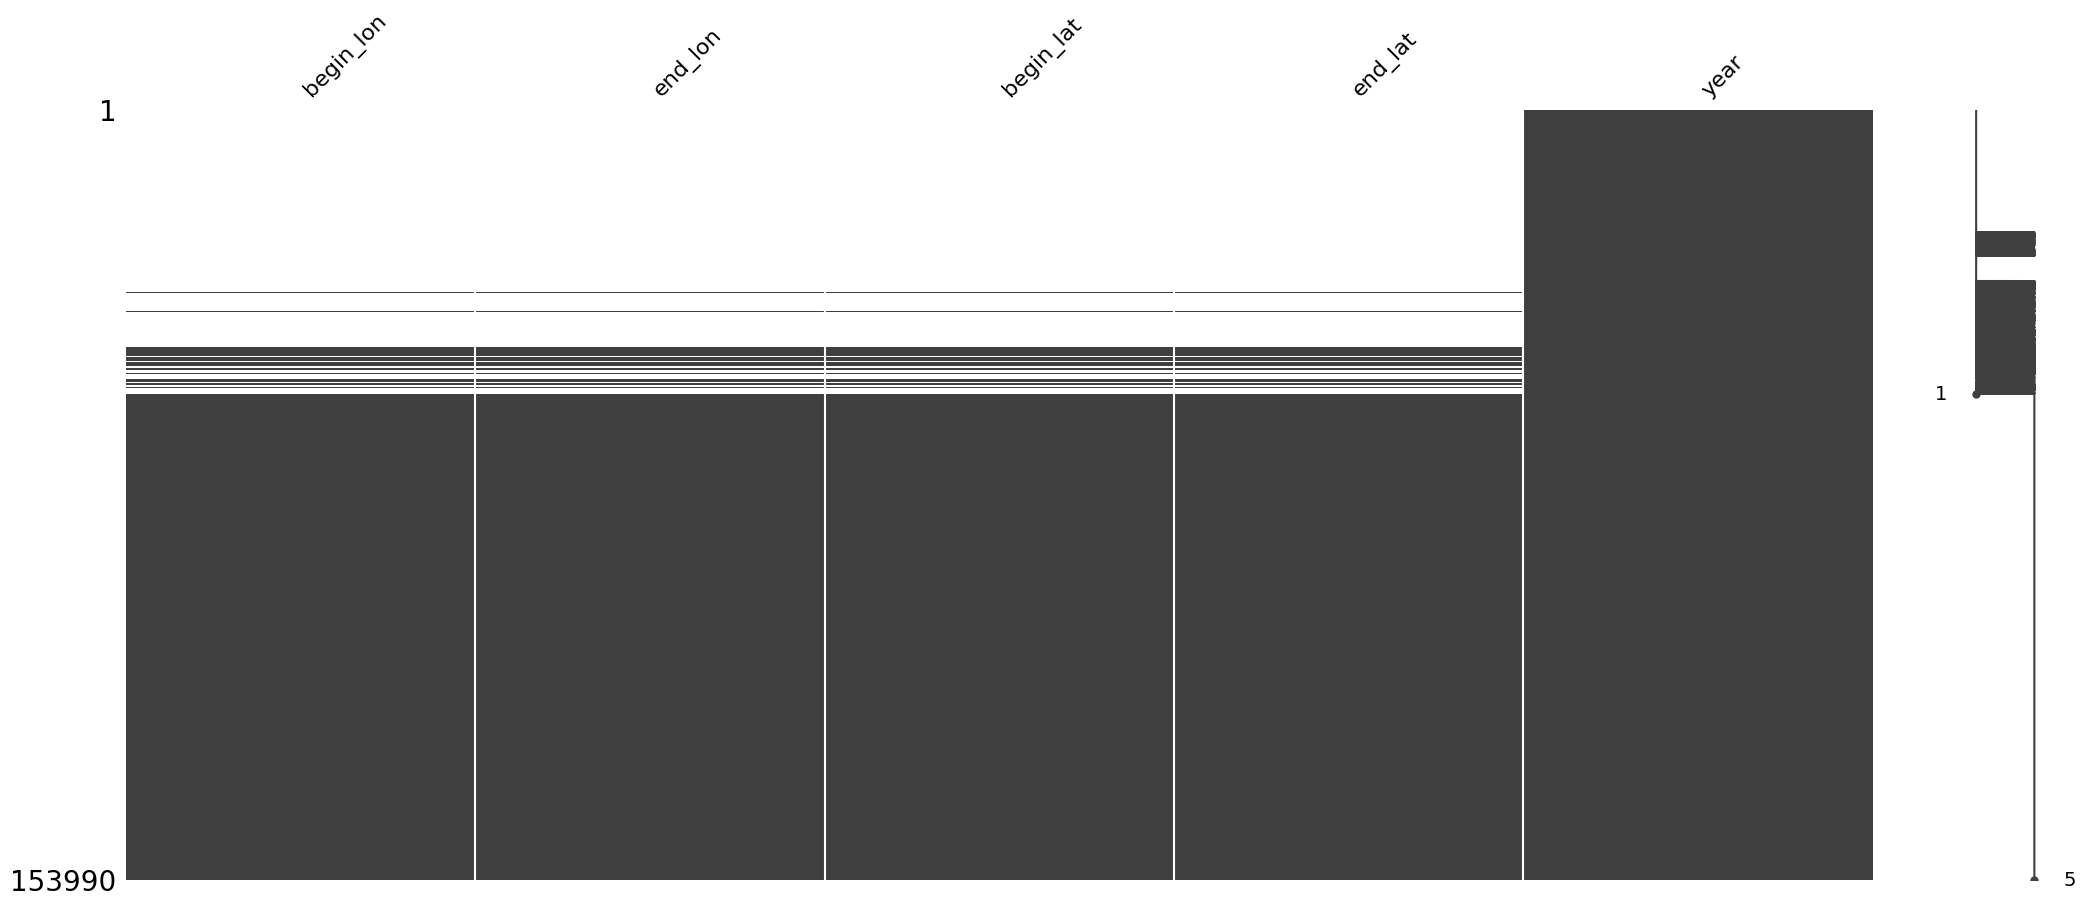

In [89]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'year']].sort_values('year'))

<Axes: >

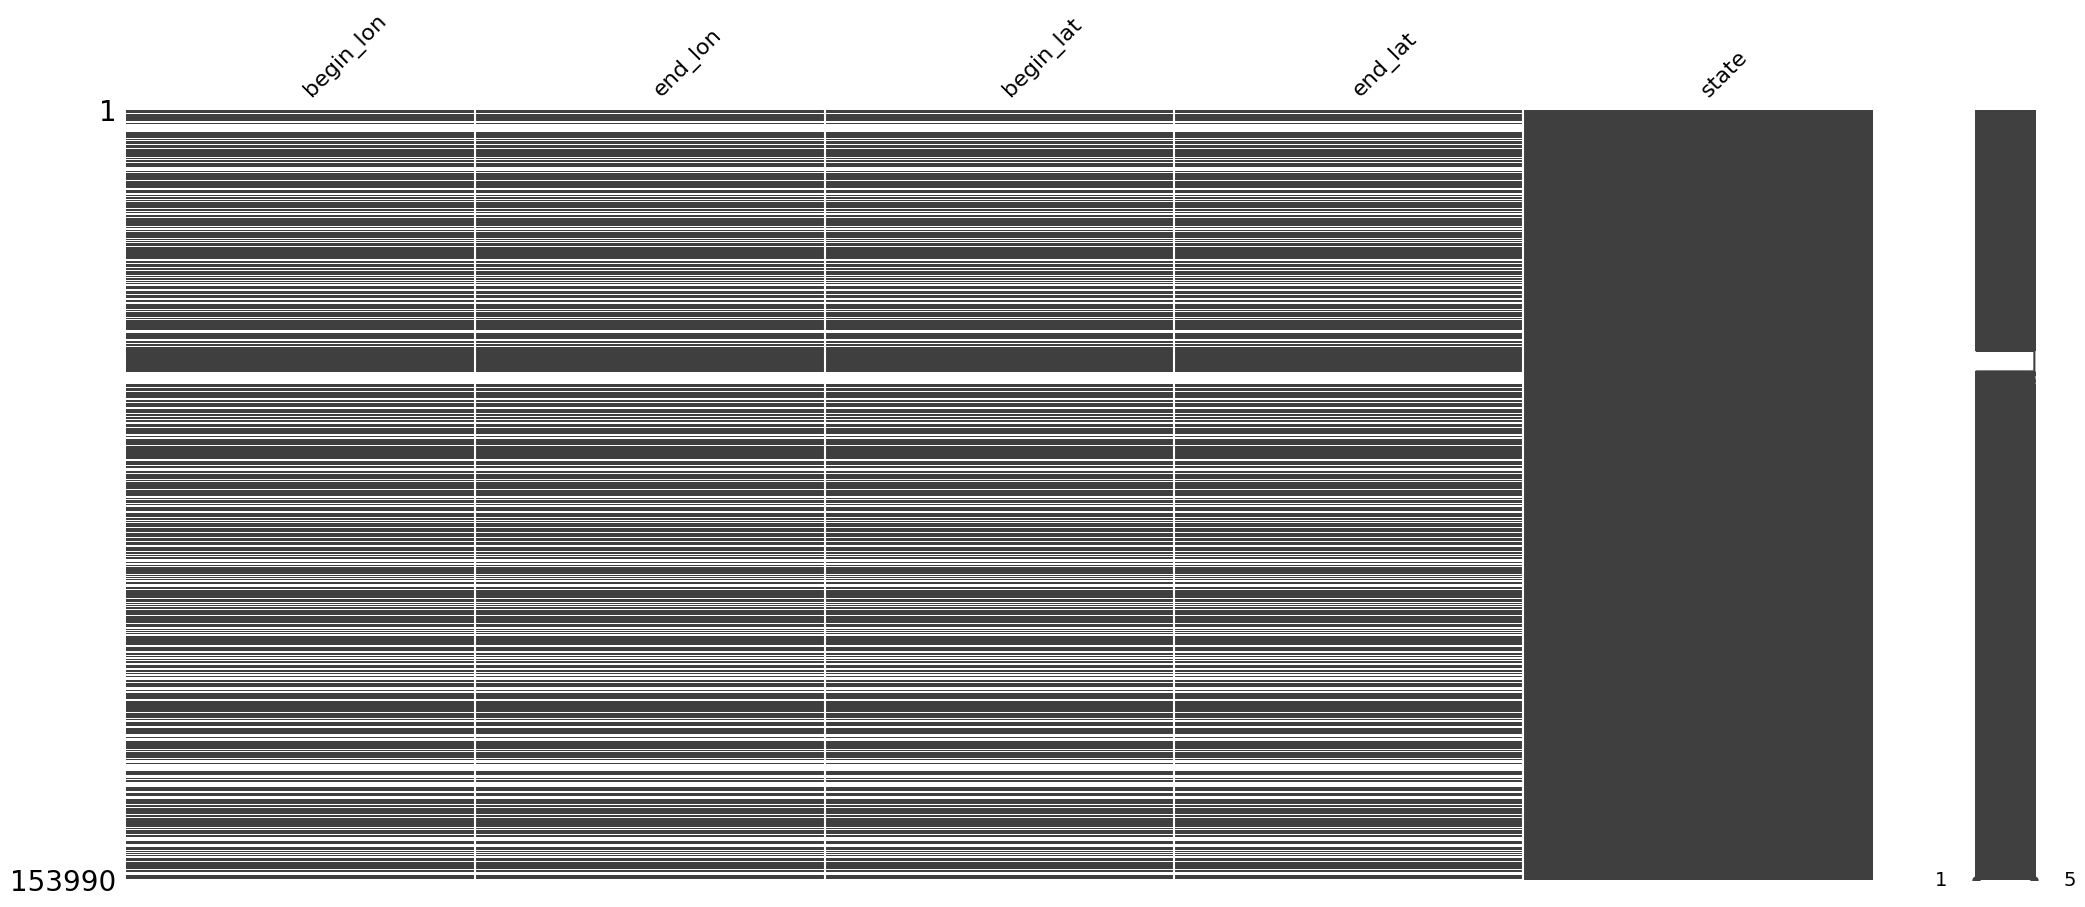

In [90]:
msno.matrix(df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat', 'state']].sort_values('state'))

In [77]:
df_missingloc = df_flood_drop.loc[df_flood_drop[['begin_lon', 'end_lon', 'begin_lat', 'end_lat']].isna().sum(1) == 4, :]
df_missingloc['year'].value_counts().sort_index()  / df_flood_drop.groupby('year').count()['event_id'] * 100

year
1996    100.000000
1997    100.000000
1998    100.000000
1999    100.000000
2000    100.000000
2001     96.596367
2002    100.000000
2003     95.012107
2004     96.599914
2005     24.605452
2006     63.469493
2007           NaN
2008           NaN
2009           NaN
2010           NaN
2011           NaN
2012           NaN
2013           NaN
2014           NaN
2015           NaN
2016           NaN
2017           NaN
2018           NaN
2019           NaN
2020           NaN
2021           NaN
dtype: float64

Looks like most missing data is in early years. We'll drop missing for now, but note the percentage of missing lat/long for 2005 and 2006 may make those years less helpful. 

In [92]:
# df_flood_drop = 
df_flood_drop2 = df_flood_drop.dropna(subset=['begin_lon', 'end_lon', 'begin_lat', 'end_lat'])
print(len(df_flood_drop), len(df_flood_drop2))

153990 103535


In [94]:
#import 2020 census zip code tabulation areas
zcta = gpd.read_file('https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/tl_2020_us_zcta520.zip')

zcta

,ZCTA5CE20,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,35592,35592,B5,G6350,S,298552385,235989,+33.7427261,-088.0973903,"POLYGON ((-88.24735 33.65390, -88.24713 33.654..."
1,35616,35616,B5,G6350,S,559506992,41870756,+34.7395036,-088.0193814,"POLYGON ((-88.13997 34.58184, -88.13995 34.582..."
2,35621,35621,B5,G6350,S,117838488,409438,+34.3350314,-086.7270557,"POLYGON ((-86.81659 34.34960, -86.81649 34.349..."
3,35651,35651,B5,G6350,S,104521045,574316,+34.4609087,-087.4801507,"POLYGON ((-87.53087 34.42492, -87.53082 34.429..."
4,36010,36010,B5,G6350,S,335675180,236811,+31.6598950,-085.8128958,"POLYGON ((-85.95712 31.67744, -85.95676 31.677..."
...,...,...,...,...,...,...,...,...,...,...
33786,10540,10540,B5,G6350,S,1394970,27777,+41.3259819,-073.7277119,"POLYGON ((-73.73580 41.33577, -73.73501 41.335..."
33787,23081,23081,B5,G6350,S,7753698,14654483,+37.1935699,-076.7525080,"POLYGON ((-76.79774 37.21409, -76.79134 37.220..."
33788,23147,23147,B5,G6350,S,143646,0,+37.3696361,-077.0391136,"POLYGON ((-77.04292 37.36996, -77.04143 37.370..."
33789,23298,23298,B5,G6350,S,288664,0,+37.5417074,-077.4295300,"POLYGON ((-77.43285 37.54038, -77.43261 37.540..."


In [95]:
#### merge zcta data to flood dataset
df_loc = pd.DataFrame([Point(str(x),str(y)) for x, y in zip(df_flood['begin_lon'], df_flood['begin_lat'])], columns=['locstr'])
df_loc.index = df_flood_drop['event_id']

gdf_flood = gpd.GeoDataFrame(df_loc, geometry='locstr', crs='EPSG:4269')
gdf_zcta = gpd.sjoin(gdf_flood, zcta, how='left')


Confirmed visual on maps that events with missing zip code were outside the census mapped ZCTA areas and so were removed. 

In [98]:
##load census API Key

load_dotenv()
API_KEY = os.getenv('census_api_key')


In [99]:
##merge zip code back to flood data, remove events with missing zip code

df_flood_zip = df_flood_drop.merge(gdf_zcta[['ZCTA5CE20']], how='inner', left_on='event_id', right_index=True)
df_flood_zip = df_flood_zip.dropna(subset='ZCTA5CE20')
df_flood_zip.head()

,begin_yearmonth,begin_day,begin_time,end_yearmonth,end_day,end_time,episode_id,event_id,state,state_fips,...,end_azimuth,end_location,begin_lat,begin_lon,end_lat,end_lon,episode_narrative,event_narrative,data_source,ZCTA5CE20
1426,200111,26,2100,200111,26,2300,1125447,5276096,TENNESSEE,47,...,NaN,COVINGTON,35.61667,-88.83333,35.61667,-88.83333,NaN,Several buildings had water in their basements...,PDS,38301
7965,200104,4,1800,200104,4,2300,1113012,5240447,MISSISSIPPI,28,...,NaN,COUNTYWIDE,32.75,-89.25,32.75,-89.25,NaN,A significant flash flood event occurred due t...,PDS,39350
8121,200103,2,1530,200103,2,1730,1112592,5238548,MISSISSIPPI,28,...,NaN,HATTIESBURG,31.41667,-89.83333,31.41667,-89.83333,NaN,Localized flooding of roads occurred in wester...,PDS,39427
8122,200103,2,1530,200103,2,1800,1112592,5238549,MISSISSIPPI,28,...,NaN,HATTIESBURG,31.45,-89.75,31.45,-89.75,NaN,Localized flooding occurred on the streets in ...,PDS,39421
8124,200103,3,400,200103,3,600,1112592,5238551,MISSISSIPPI,28,...,NaN,COUNTYWIDE,31.41667,-89.55,31.38333,-89.55,NaN,A few roads in the county had flooding.,PDS,39482


In [100]:
##definte census data variables to pull, and the data label

fields_dict = {'NAME': 'Name',
               'B19081_001E': 'houseinc_1',
               'B19081_002E': 'houseinc_2',
               'B19081_003E': 'houseinc_3',
               'B19081_004E': 'houseinc_4',
               'B19081_005E': 'houseinc_5',
               'B19081_006E': 'houseinc_top5',
               'B19013_001E': 'med_houseinc_12mon',
               'B19058_001E': 'household_public_assistance1'
              }

fields = ','.join(list(fields_dict.keys()))
names = list(fields_dict.values()) + ['zcta']


In [101]:
### request data from api, put into dataframe

url = 'https://api.census.gov/data/2022/acs/acs5?get=' + fields + '&for=zip%20code%20tabulation%20area:*&key=' + API_KEY

r_test = requests.get(url)
r_test.json()
df_census = pd.DataFrame(r_test.json()[1::], columns=names)

df_census.head()

,Name,houseinc_1,houseinc_2,houseinc_3,houseinc_4,houseinc_5,houseinc_top5,med_houseinc_12mon,household_public_assistance1,zcta
0,ZCTA5 00601,3852,10764,17479,26997,56362,96549,17526,5341,00601
1,ZCTA5 00602,4160,12496,20599,33220,73001,118717,20260,12777,00602
2,ZCTA5 00603,1427,9622,18169,34313,88526,154617,17703,19624,00603
3,ZCTA5 00606,2967,10850,19373,30163,55892,78806,19603,1948,00606
4,ZCTA5 00610,5104,13917,23066,35958,78734,129039,22796,8781,00610


In [115]:
### merge census geography info w flood and zcta dataw flood data
## only keep census zctas that have flood data

df_cen_fl = df_census.merge(df_flood_zip, how='right', left_on='zcta', right_on='ZCTA5CE20')
df_cen_fl.head().T
# df_cen_fl.columns

,0,1,2,3,4
Name,ZCTA5 38301,ZCTA5 39350,ZCTA5 39427,ZCTA5 39421,ZCTA5 39482
houseinc_1,7529,10534,None,11984,20482
houseinc_2,21138,26445,None,27250,46638
houseinc_3,38556,47945,None,46523,65911
houseinc_4,63966,82542,None,82220,87376
houseinc_5,140623,163619,None,151058,171590
houseinc_top5,240169,265703,None,195167,267355
med_houseinc_12mon,37692,48008,53264,48750,65092
household_public_assistance1,13366,8198,479,1058,4206
zcta,38301,39350,39427,39421,39482


Exploring missing values in the merged dataset

97 floods don't have census data, and they're in the US territory islands (Virign islands, american samoa, and guam). For this project we'll limit to the lower 48 

After we limit to lower 48, 9,211 floods don't have census data for the household income quintiles or top 5 percent. I'll leave those for now but will need to revisit. 

In [139]:
states_to_drop = ['GUAM', 'VIRGIN ISLANDS', 'DISTRICT OF COLUMBIA', 'HAWAII', 'ALASKA', 'AMERICAN SAMOA', 'PUERTO RICO']

df_cen_fl_48 = df_cen_fl[~df_cen_fl['state'].isin(states_to_drop)]
df_cen_fl_48.head()

df_cen_fl_48.isna().sum()

Name                               0
houseinc_1                      9211
houseinc_2                      9211
houseinc_3                      9211
houseinc_4                      9211
houseinc_5                      9211
houseinc_top5                   9211
med_houseinc_12mon                 0
household_public_assistance1       0
zcta                               0
begin_yearmonth                    0
begin_day                          0
begin_time                         0
end_yearmonth                      0
end_day                            0
end_time                           0
episode_id                         0
event_id                           0
state                              0
state_fips                         0
year                               0
month_name                         0
event_type                         0
cz_type                            0
cz_fips                            0
cz_name                            0
wfo                                0
b

In [ ]:
## Next steps, finish duplicates, missing. 